In [97]:
import pandas as pd

dataset=pd.read_csv("data/AEP_hourly.csv")
dataset.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [98]:
dataset.shape

(121273, 2)

In [99]:
sample_data=dataset.sample(frac=0.2,random_state=42)
sample_data.shape

(24255, 2)

Text(0.5, 1.0, 'Distribution of AEP_MW')

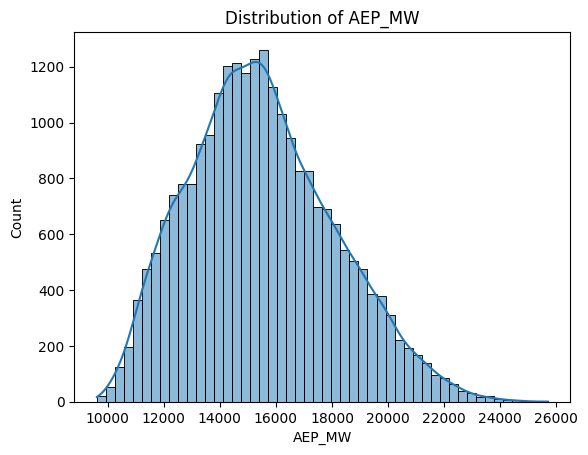

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(sample_data['AEP_MW'], bins=50, kde=True)
plt.title('Distribution of AEP_MW')

In [101]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# DO NOT fit scaler on entire dataset - will cause data leakage
# We'll fit it on training data only after the split
scaler = MinMaxScaler()

dataset["AEP_MW_scaled"] = scaler.fit_transform(dataset['AEP_MW'].values.reshape(-1, 1))


In [102]:
# Feature engineering: add lag features BEFORE dropping NaN
dataset['AEP_MW_lag_1'] = dataset['AEP_MW_scaled'].shift(1)
dataset['AEP_MW_lag_2'] = dataset['AEP_MW_scaled'].shift(2)
dataset['AEP_MW_lag_24'] = dataset['AEP_MW_scaled'].shift(24)  # Previous day same hour



In [103]:
dataset.head()

,Datetime,AEP_MW,AEP_MW_scaled,AEP_MW_lag_1,AEP_MW_lag_2,AEP_MW_lag_24
0,2004-12-31 01:00:00,13478.0,0.241839,NaN,NaN,NaN
1,2004-12-31 02:00:00,12865.0,0.203798,0.241839,NaN,NaN
2,2004-12-31 03:00:00,12577.0,0.185925,0.203798,0.241839,NaN
3,2004-12-31 04:00:00,12517.0,0.182202,0.185925,0.203798,NaN
4,2004-12-31 05:00:00,12670.0,0.191697,0.182202,0.185925,NaN


In [104]:
dataset.dropna(inplace=True)

In [105]:
dataset['Datetime'] = pd.to_datetime(dataset['Datetime'])

# Extract components of the Datetime column
dataset['Year'] = dataset['Datetime'].dt.year
dataset['Month'] = dataset['Datetime'].dt.month
dataset['Day'] = dataset['Datetime'].dt.day
dataset['Hour'] = dataset['Datetime'].dt.hour

In [106]:
# Add cyclic encoding for temporal features
# This treats periodic features (Month, Hour, Day) as circular

# Month: Cyclical encoding (12 months in a year)
dataset['Month_sin'] = np.sin(2 * np.pi * dataset['Month'] / 12)
dataset['Month_cos'] = np.cos(2 * np.pi * dataset['Month'] / 12)

# Hour: Cyclical encoding (24 hours in a day)
dataset['Hour_sin'] = np.sin(2 * np.pi * dataset['Hour'] / 24)
dataset['Hour_cos'] = np.cos(2 * np.pi * dataset['Hour'] / 24)

# Day of week from Datetime
dataset['DayOfWeek'] = dataset['Datetime'].dt.dayofweek
dataset['DayOfWeek_sin'] = np.sin(2 * np.pi * dataset['DayOfWeek'] / 7)
dataset['DayOfWeek_cos'] = np.cos(2 * np.pi * dataset['DayOfWeek'] / 7)

print("Cyclic features added successfully")
print(dataset[['Month', 'Month_sin', 'Month_cos', 'Hour', 'Hour_sin', 'Hour_cos']].head())


Cyclic features added successfully
    Month     Month_sin  Month_cos  Hour  Hour_sin  Hour_cos
24     12 -2.449294e-16        1.0     1  0.258819  0.965926
25     12 -2.449294e-16        1.0     2  0.500000  0.866025
26     12 -2.449294e-16        1.0     3  0.707107  0.707107
27     12 -2.449294e-16        1.0     4  0.866025  0.500000
28     12 -2.449294e-16        1.0     5  0.965926  0.258819


In [107]:
feature_columns = [
    'Month_sin', 'Month_cos',           # Cyclic month
    'Hour_sin', 'Hour_cos',             # Cyclic hour
    'DayOfWeek_sin', 'DayOfWeek_cos',   # Cyclic day of week
    'AEP_MW_lag_1', 'AEP_MW_lag_2',     # Recent lags
    'AEP_MW_lag_24'                     # Previous day same hour (seasonality)
]

# Drop rows with NaN in any feature column
dataset_clean = dataset[feature_columns + ['AEP_MW_scaled']].dropna()

X = dataset_clean[feature_columns].values
y = dataset_clean['AEP_MW_scaled'].values


In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Train set: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set: X_test={X_test.shape}, y_test={y_test.shape}")


feature_scaler = MinMaxScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)  # Use training stats for test

Train set: X_train=(96999, 9), y_train=(96999,)
Test set: X_test=(24250, 9), y_test=(24250,)


In [109]:
import torch 

# Use the properly scaled data
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [110]:
import torch.nn as nn

class EnergyConsumptionModel(nn.Module):
    def __init__(self, input_size):
        super(EnergyConsumptionModel, self).__init__()
        # Input -> Hidden layers with batch norm and dropout
        self.fc1 = nn.Linear(input_size, 128)      # Increased hidden layer
        self.bn1 = nn.BatchNorm1d(128)             # Batch normalization
        self.dropout1 = nn.Dropout(0.3)            # Dropout 30%
        
        self.fc2 = nn.Linear(128, 64)              # Second hidden layer
        self.bn2 = nn.BatchNorm1d(64)              
        self.dropout2 = nn.Dropout(0.2)            # Dropout 20%
        
        self.fc3 = nn.Linear(64, 32)               # Third hidden layer
        self.fc4 = nn.Linear(32, 1)                # Output layer (regression)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = torch.relu(x)
        
        x = self.fc4(x)  # No activation for regression
        return x


In [111]:
input_size = X_train.shape[1]  # Number of features
model = EnergyConsumptionModel(input_size)

In [112]:
from torch import optim

criterion = nn.MSELoss()
# Use a better optimizer with learning rate scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

In [113]:
from tqdm import tqdm
epochs = 200

train_losses = []
val_losses = []

for epoch in tqdm(range(epochs)):
    model.train()
    optimizer.zero_grad()
    
    y_train_pred = model(X_train_tensor)
    train_loss = criterion(y_train_pred, y_train_tensor)
    
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())
    
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_test_tensor)
        val_loss = criterion(y_val_pred, y_test_tensor)
    val_losses.append(val_loss.item())
    
    scheduler.step(val_loss)
    
    # Print progress
    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss.item():.6f} | Val Loss: {val_loss.item():.6f}')


 10%|█         | 20/200 [00:07<01:07,  2.68it/s]

Epoch [20/200] | Train Loss: 0.016007 | Val Loss: 0.055311


 20%|██        | 40/200 [00:16<01:47,  1.49it/s]

Epoch [40/200] | Train Loss: 0.009536 | Val Loss: 0.013850


 30%|███       | 60/200 [00:28<01:19,  1.75it/s]

Epoch [60/200] | Train Loss: 0.007862 | Val Loss: 0.007471


 40%|████      | 80/200 [00:40<01:07,  1.78it/s]

Epoch [80/200] | Train Loss: 0.006854 | Val Loss: 0.005204


 50%|█████     | 100/200 [00:52<00:53,  1.87it/s]

Epoch [100/200] | Train Loss: 0.006074 | Val Loss: 0.004506


 60%|██████    | 120/200 [01:05<01:05,  1.23it/s]

Epoch [120/200] | Train Loss: 0.005488 | Val Loss: 0.004265


 70%|███████   | 140/200 [01:17<00:31,  1.92it/s]

Epoch [140/200] | Train Loss: 0.004995 | Val Loss: 0.004090


 80%|████████  | 160/200 [01:28<00:26,  1.48it/s]

Epoch [160/200] | Train Loss: 0.004597 | Val Loss: 0.003944


 90%|█████████ | 180/200 [01:41<00:11,  1.69it/s]

Epoch [180/200] | Train Loss: 0.004264 | Val Loss: 0.003867


100%|██████████| 200/200 [01:53<00:00,  1.76it/s]

Epoch [200/200] | Train Loss: 0.003987 | Val Loss: 0.003796


In [114]:
model.eval()

# Make predictions on test set
with torch.no_grad():
    y_pred_test = model(X_test_tensor)

# Convert to numpy
y_pred_test_np = y_pred_test.numpy()

y_pred_original = scaler.inverse_transform(y_pred_test_np)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

print(f"Predicted range: {y_pred_original.min():.2f} - {y_pred_original.max():.2f}")
print(f"Actual range: {y_test_original.min():.2f} - {y_test_original.max():.2f}")


Predicted range: 10268.16 - 22005.90
Actual range: 9581.00 - 24739.00


In [115]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate metrics on original scale
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)
mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100


print("\nSample predictions vs actual (first 20 samples):")
comparison = pd.DataFrame({
    'Actual': y_test_original[:20].flatten(),
    'Predicted': y_pred_original[:20].flatten(),
    'Error': np.abs(y_test_original[:20].flatten() - y_pred_original[:20].flatten()),
    'Error%': np.abs((y_test_original[:20].flatten() - y_pred_original[:20].flatten()) / y_test_original[:20].flatten()) * 100
})
print(comparison)



Sample predictions vs actual (first 20 samples):
     Actual     Predicted        Error     Error%
0   15317.0  14260.975586  1056.024414   6.894460
1   14786.0  13917.681641   868.318359   5.872571
2   14391.0  13539.619141   851.380859   5.916065
3   14384.0  13200.147461  1183.852539   8.230343
4   14479.0  13287.551758  1191.448242   8.228802
5   15273.0  13624.714844  1648.285156  10.792151
6   15809.0  14304.614258  1504.385742   9.516008
7   15821.0  14846.730469   974.269531   6.158078
8   15624.0  14739.556641   884.443359   5.660800
9   15188.0  14273.918945   914.081055   6.018443
10  14652.0  13125.051758  1526.948242  10.421432
11  18461.0  14456.321289  4004.678711  21.692642
12  18462.0  16149.548828  2312.451172  12.525464
13  18544.0  17752.582031   791.417969   4.267785
14  18793.0  18289.513672   503.486328   2.679116
15  19235.0  18816.701172   418.298828   2.174675
16  20072.0  19236.675781   835.324219   4.161639
17  21412.0  19606.742188  1805.257812   8.431056


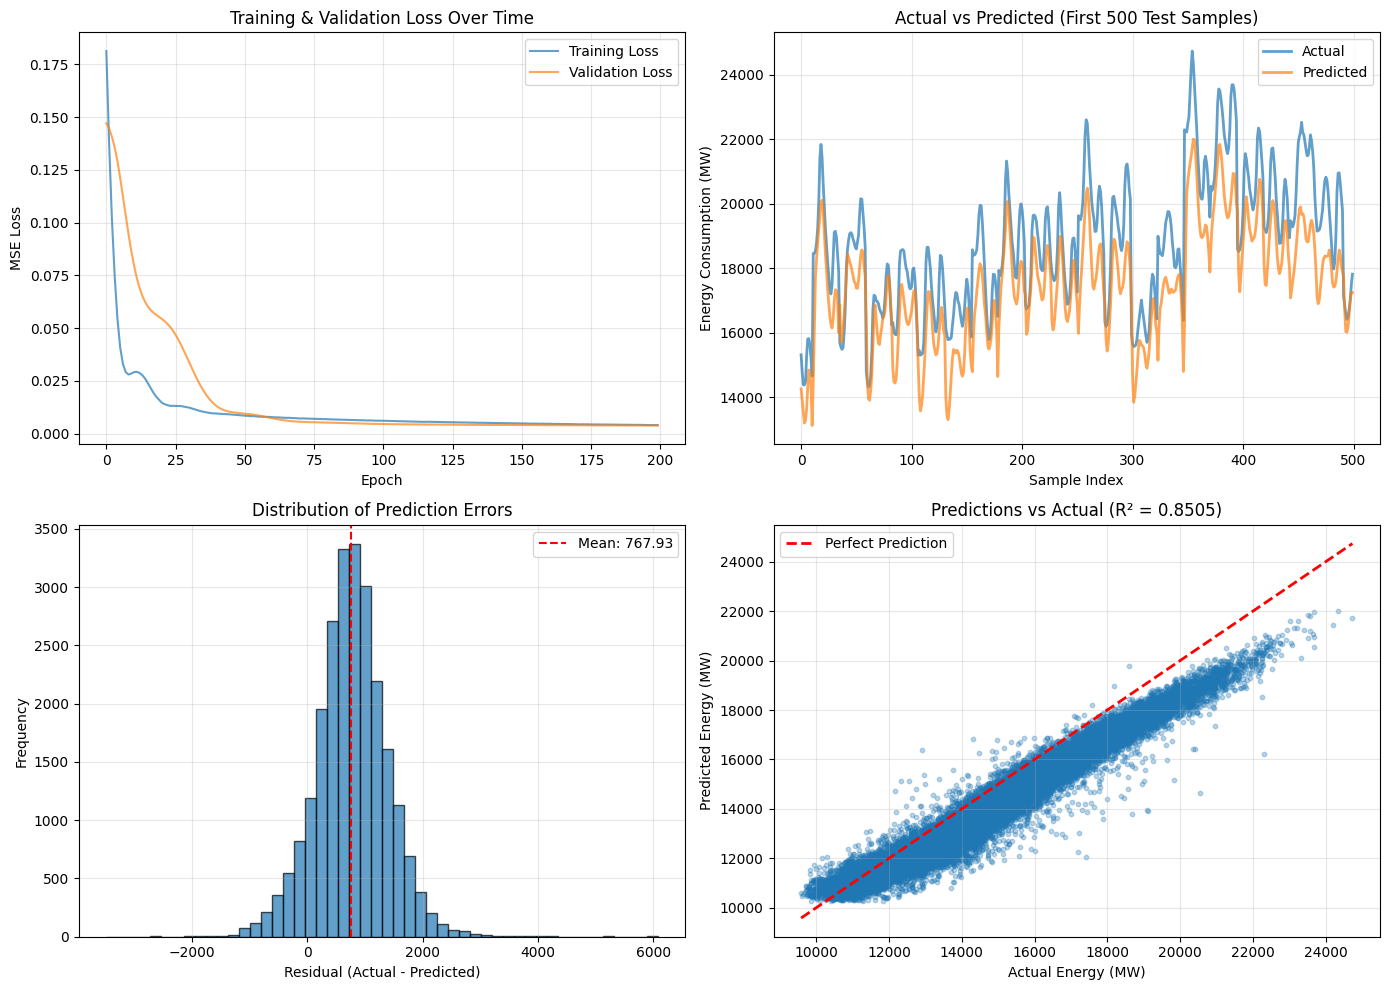

In [116]:
# Visualization: Training curves and predictions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Training Loss Curve
axes[0, 0].plot(train_losses, label='Training Loss', alpha=0.7)
axes[0, 0].plot(val_losses, label='Validation Loss', alpha=0.7)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('MSE Loss')
axes[0, 0].set_title('Training & Validation Loss Over Time')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Actual vs Predicted (first 500 samples)
axes[0, 1].plot(y_test_original[:500], label='Actual', alpha=0.7, linewidth=2)
axes[0, 1].plot(y_pred_original[:500], label='Predicted', alpha=0.7, linewidth=2)
axes[0, 1].set_xlabel('Sample Index')
axes[0, 1].set_ylabel('Energy Consumption (MW)')
axes[0, 1].set_title('Actual vs Predicted (First 500 Test Samples)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuals Distribution
residuals = y_test_original.flatten() - y_pred_original.flatten()
axes[1, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(residuals.mean(), color='red', linestyle='--', label=f'Mean: {residuals.mean():.2f}')
axes[1, 0].set_xlabel('Residual (Actual - Predicted)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Prediction Errors')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Scatter: Predicted vs Actual
axes[1, 1].scatter(y_test_original, y_pred_original, alpha=0.3, s=10)
# Add diagonal line (perfect prediction)
min_val = min(y_test_original.min(), y_pred_original.min())
max_val = max(y_test_original.max(), y_pred_original.max())
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual Energy (MW)')
axes[1, 1].set_ylabel('Predicted Energy (MW)')
axes[1, 1].set_title(f'Predictions vs Actual (R² = {r2:.4f})')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
